# 1. Import libraries

In [2]:
# Import necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import DirectoryIterator

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
# From here, add any libraries that you might need for the rest of your code
# Check if running in Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Mount Google Drive if in Google Colab
if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)  # Mounts Google Drive for each user in Colab
    print("Google Drive mounted successfully in Colab.")

else:
    # If running in a local Jupyter Notebook, ensure the necessary path is set
    print("Running outside Google Colab. Please ensure necessary paths are correctly set in Jupyter Notebook.")


Running outside Google Colab. Please ensure necessary paths are correctly set in Jupyter Notebook.


# 2. Load and pre-process the dataset

In [3]:
# Set the paths based on your Drive directory
data_dir ='C:/Users/kjg54/Desktop/Master degree/Courses by block/Courses(block1)/Deep Learning (Fall)/New Block/Group assignment/data' # Change to the path to your directory

train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: C:/Users/kjg54/Desktop/Master degree/Courses by block/Courses(block1)/Deep Learning (Fall)/New Block/Group assignment/data
Training directory: C:/Users/kjg54/Desktop/Master degree/Courses by block/Courses(block1)/Deep Learning (Fall)/New Block/Group assignment/data\Training
Testing directory: C:/Users/kjg54/Desktop/Master degree/Courses by block/Courses(block1)/Deep Learning (Fall)/New Block/Group assignment/data\Testing


*   This code loads images from directories, adds noise to them, rescales them, and prepares them for training/testing
*   Training data is shuffled and processed in batches of 32 images.
    *   Shuffle for Training: Helps the model generalize by presenting the data in a different order, reducing the risk of model overfitting or learning the order of the data.
    *   No shuffle for Testing: It keeps the test data in the same order, so the evaluation is consistent and reliable.

*   The images are resized to 30x30 pixels, and their pixel values are normalized between 0 and 1.
*   Classes are one-hot encoded, which is important for multi-class classification problems.





In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
# add_noise : To add random Gaussian noise to each image, which can help the model generalize better by preventing it from memorizing training data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30 # resized to 30x30 pixels for processing
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, # Rescales image pixel values from [0,255] to [0,1]
                                 preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=True,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=False,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

*   Visualise random 15 samples from the dataset. Image should be displayed with its corresponding label as text on top of the image.

***The issue with the images not appearing clearly when using this function would be several factors:
     1. Resize to 30x30 pixels
     2. Add_noise function





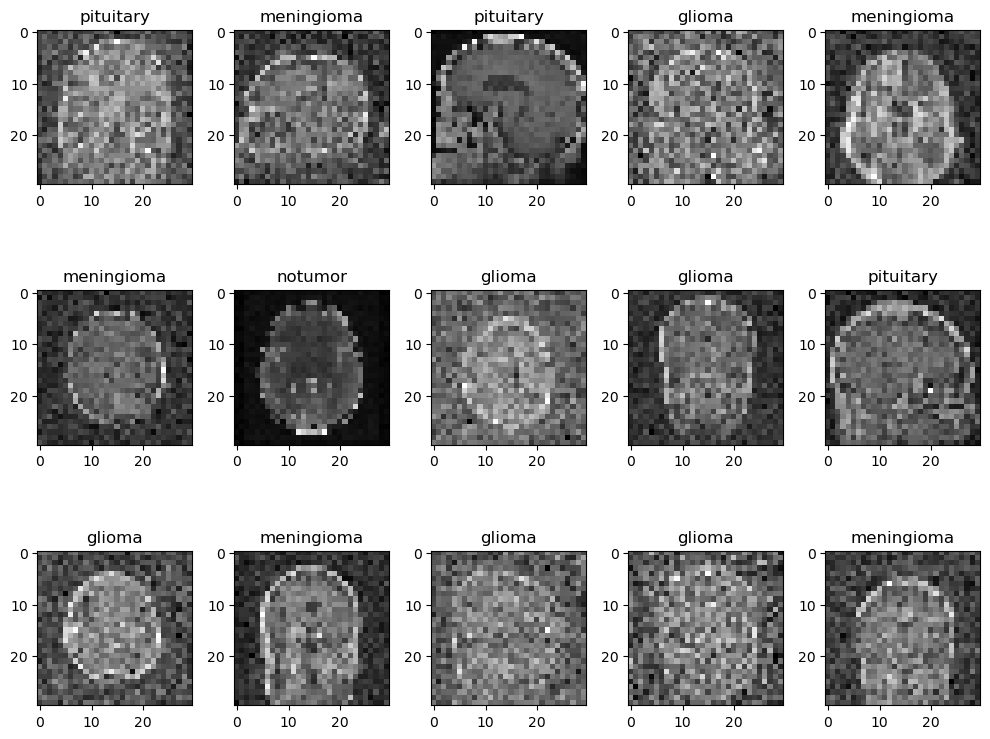

In [5]:
# Function to display 15 random samples from the dataset
def display_random_samples(data_gen, num_samples=15):
    images, labels = next(data_gen)  # Get one batch of images
    indices = random.sample(range(len(images)), num_samples)  # Randomly select 15 images

    plt.figure(figsize=(10, 8))
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i+1)  # Arrange in a grid 3x5
        img = images[idx].squeeze()  # Squeeze to remove any singleton dimensions (if grayscale)
        plt.imshow(img, cmap='gray')  # Assuming grayscale
        label_idx = np.argmax(labels[idx])  # Get the class label index
        class_label = [k for k, v in train_data.class_indices.items() if v == label_idx][0]
        plt.title(class_label)
    plt.tight_layout()
    plt.show()

# Call the function to display 15 random samples from the training data
display_random_samples(train_data)

*   Create a bar plot to visulaize the class label distribution of the dataset




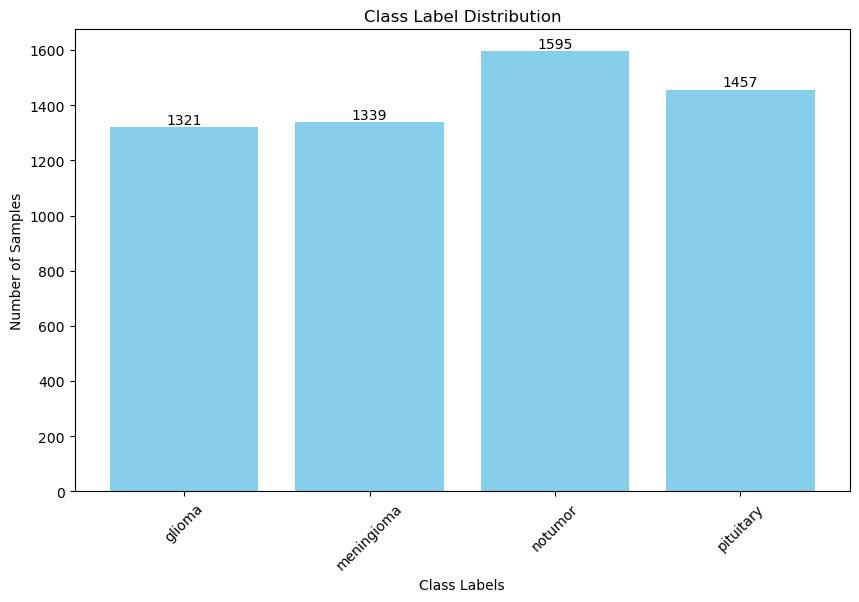

In [6]:
# Create a bar plot to visualize the class label distribution
def plot_class_distribution(data_gen):
    class_labels = list(data_gen.class_indices.keys())  # Get class labels
    num_samples = list(data_gen.classes)  # List of classes for all samples
    class_count = np.bincount(num_samples)  # Count of each class

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, class_count, color='skyblue')

    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Class Label Distribution')
    plt.xticks(rotation=45)

    # Add the total number on top of each bar
    for bar, count in zip(bars, class_count):
        yval = bar.get_height()  # Height of the bar (number of samples)
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(count)}', ha='center', va='bottom')

    plt.show()

# Call the function to create the class distribution plot
plot_class_distribution(train_data)


# 4. Train and Evaluation functions

*   Implement the baseline CNN algorithm without any modification for both model and dataset.

  1.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLU activations followed by a max pooling layer of size 2 x 2
  2.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLu activations followed by a max pooling layer of size 2 x 2
  3.   Flatten the 3D output
  4.   Desn layers of sizes 32 and with Relu activation
  5.   Output layer with softmax activation are added for multi-class classification
  6. The optimizer should be Adam, metric should be acrruracy. The categorical crossentropy loss function is used for multi-class classification problems.







In [7]:
# CNN to classify grayscale images (30x30pixels) into different categories.
# Correct input shape for grayscale images (30x30 pixels, 1 channel)
img_shape = (30, 30, 1)  # 30x30 pixels, 1 channel (grayscale)
model = models.Sequential()

# first convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = img_shape)) #relu helps to introduce non-linearity
model.add(layers.MaxPooling2D((2,2)))

# second convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten the 3D output from the convolutional layers into 1D
model.add(layers.Flatten())

# Dense layer with 32 units and ReLU activation
model.add(layers.Dense(32, activation = 'relu'))

num_classes = len(list(train_data.class_indices.keys()))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

# Summary of the model
model.summary()

C:\Users\kjg54\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

*   Analyze the performance of the baseline by plotting
  1.   **Split the training data and validation data again due to the restriction of not modifying the preprocessing code.**
      
      -> Given that it's not allowed to modify the original preprocessing code and it's already loaded train_data and test_data using the ImageDataGenerator, we need a solution that follows the rule but still allows you to create a validation set from the training data.

      Since we're using ImageDataGenerator to load both the training and test data, the easiest way to create a validation set without modifying the original code is to split the training data after loading it.
  2.   The training and validation losses and accuracies on the training and validation set through epochs
  3.   The Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score and a confusion matrix for the validation and test sets.
  4.   Report performance measures (accuracy, precision, recall, and F1-score) for both validation and test sets.






In [8]:
# Collect all images and labels from the train_data generator
x_data = []
y_data = []

# Loop through the generator to collect data
for i in range(len(train_data)):
    images, labels = next(train_data)
    x_data.extend(images)
    y_data.extend(labels)

# Convert lists to NumPy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Now you can use x_train, y_train for training and x_val, y_val for validation.
print("Split the training and validation data successfully.")
print(f"Number of training samples: {len(x_train)}")  # Should show 80% of total
print(f"Number of validation samples: {len(x_val)}")  # Should show 20% of total
print(f"Number of validation samples: {test_data.samples}")


Split the training and validation data successfully.
Number of training samples: 4569
Number of validation samples: 1143
Number of validation samples: 1311


In [9]:
# Train the model with NumPy arrays
history = model.fit(
    x_train,  # Training data (images)
    y_train,  # Training data (labels)
    validation_data=(x_val, y_val),  # Validation data (images and labels)
    epochs=10,
    shuffle=True
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4078 - loss: 1.2235 - val_accuracy: 0.6789 - val_loss: 0.8357
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7077 - loss: 0.7884 - val_accuracy: 0.7288 - val_loss: 0.6959
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7257 - loss: 0.7123 - val_accuracy: 0.7655 - val_loss: 0.6290
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7745 - loss: 0.6081 - val_accuracy: 0.7568 - val_loss: 0.6345
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7899 - loss: 0.5657 - val_accuracy: 0.7445 - val_loss: 0.6162
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7973 - loss: 0.5455 - val_accuracy: 0.7865 - val_loss: 0.5549
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8129 - loss: 0.5006 - val_accuracy: 0.7708 - val_loss: 0.5657
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8344 - loss: 0.4559 - val_accu

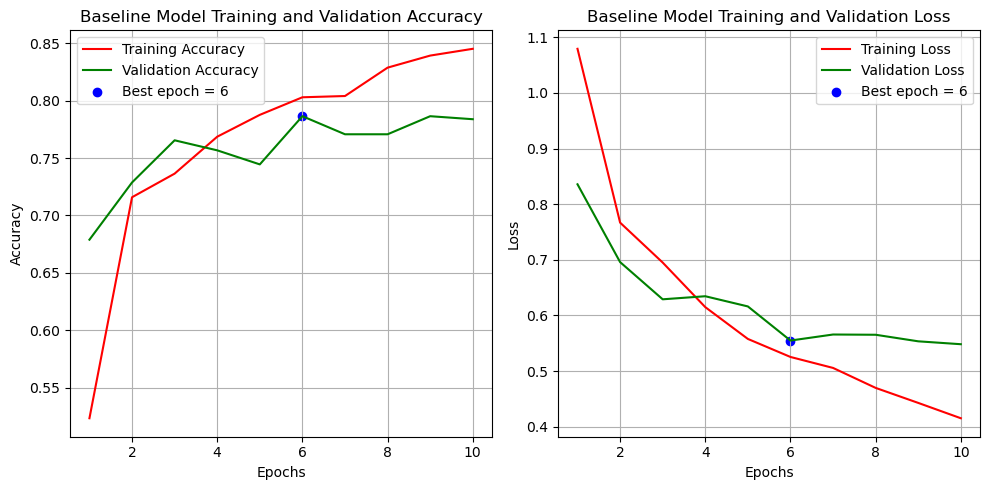

In [10]:
# Assuming 'history' is the variable that holds the result of model.fit()
np.random.seed(42)

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'g', label='Validation Accuracy')
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation accuracy
    best_epoch_acc = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
    plt.scatter(best_epoch_acc, max(history.history['val_accuracy']), label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'g', label='Validation Loss')
    plt.title('Baseline Model Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation loss based on the best validation accuracy epoch
    plt.scatter(best_epoch_acc, history.history['val_loss'][best_epoch_acc - 1], label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the history object returned from model.fit()
plot_training_history(history)

In [11]:
# Create a tensorFlow Dataset for your validation data
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(32)  # Set batch size to match other data generators


In [12]:
def plot_multiclass_roc_and_confusion_matrix(model, data_gen, class_names, set_type='Validation'):
    y_true = []
    y_pred = []

    # Check if data_gen is a TensorFlow Dataset object or a generator
    if isinstance(data_gen, tf.data.Dataset):
        # Collect true labels and predicted probabilities from Dataset
        for images, labels in data_gen:
            preds = model.predict(images)
            y_true.extend(np.argmax(labels, axis=1))
            y_pred.extend(preds)
    else:
        # Collect true labels and predicted probabilities from generator
        for images, labels in data_gen:
            preds = model.predict(images)
            y_true.extend(np.argmax(labels, axis=1))
            y_pred.extend(preds)
            if len(y_true) >= data_gen.samples:
                break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Binarize the output for ROC calculations
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])
    n_classes = y_true_binarized.shape[1]

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC and Confusion Matrix
    plt.figure(figsize=(10, 5))

    # Plot ROC curve
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {set_type} Set')
    plt.legend(loc="lower right")

    # Plot Confusion Matrix
    plt.subplot(1, 2, 2)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {set_type} Set')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

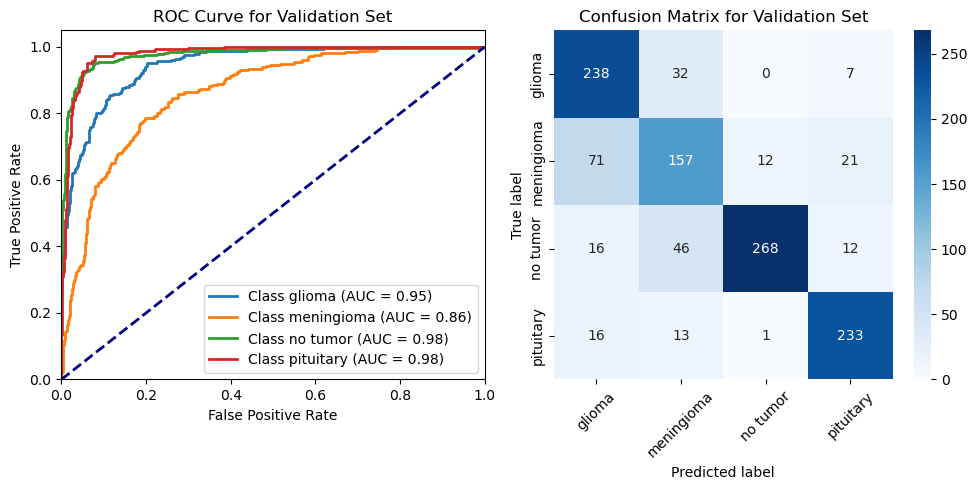

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

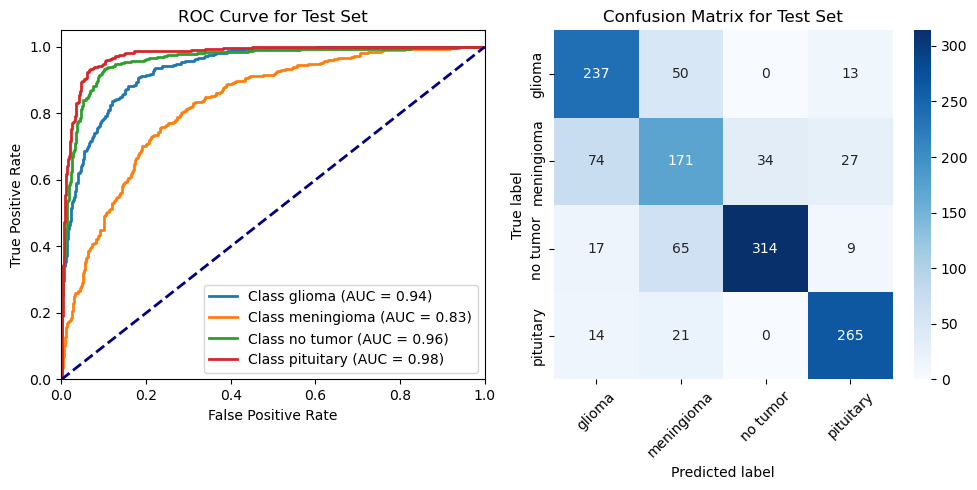

In [13]:
# Define the class names corresponding to your data
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']


# Example usage for the validation set using the custom Dataset
plot_multiclass_roc_and_confusion_matrix(model, val_dataset, class_names, set_type='Validation')

# Example usage for the test set using the DirectoryIterator
plot_multiclass_roc_and_confusion_matrix(model, test_data, class_names, set_type='Test')


# 5. Model training

# 6. Model evaluation